In [1]:
import networkx as nx
from matplotlib import pyplot as plt
import random
import math
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import pandas as pd

In [2]:
def distance(x1, y1, x2, y2):
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5
def contact_prob(distance, contact_density,x1, y1, x2, y2):
    d = distance(x1, y1, x2, y2)
    return math.exp(-d/contact_density)

In [3]:
#configuration parameters
node_count = 25 #number of nodes
infection_rate = 0.3 #probability of infection
recovery_rate = 0.1 #probability of recovery
timesteps = 100 #number of timesteps
contact_density = 1

color_map = {'S':'green', 'I':'red', 'R':'blue'}

square_size = math.sqrt(node_count) #size of square
G = nx.Graph()
for i in range(node_count):
    G.add_node(i)

custom_pos = {}
#initialize node state, color, and position
#set the colors
#S = susceptible (green)
#I = infected (red)
#R = recovered (blue)
for node in G.nodes():
    G.nodes[node]['state'] = 'S'    
    x,y = random.uniform(0, square_size), random.uniform(0, square_size)
    G.nodes[node]['pos'] = (x,y)
    G.nodes[node]['observed'] = False
    custom_pos[node] = (x,y)

In [4]:
#set the edges
for x in range(node_count):
    for y in range(x+1, node_count):
        if contact_prob(distance, contact_density, G.nodes[x]['pos'][0], G.nodes[x]['pos'][1], G.nodes[y]['pos'][0], G.nodes[y]['pos'][1]) > random.uniform(0, 1):
            G.add_edge(x,y)

In [5]:
temporal_graph_dict = {}
temporal_graph_dict[0] = G.copy()

In [6]:
def initialize_graph(node_count, distance = distance, contact_density = 1):
    square_size = math.sqrt(node_count) #size of square
    G = nx.Graph()
    for i in range(node_count):
        G.add_node(i)
    #initialize node state, color, and position
    #set the colors
    #S = susceptible (green)
    #I = infected (red)
    #R = recovered (blue)
    for node in G.nodes():
        G.nodes[node]['state'] = 'S'    
        x,y = random.uniform(0, square_size), random.uniform(0, square_size)
        G.nodes[node]['pos'] = (x,y)
        G.nodes[node]['observed'] = False
        G.nodes[node]['SIR_prob'] = [1,0,0]
        custom_pos[node] = (x,y)
    #set the edges
    for x in range(node_count):
        for y in range(x+1, node_count):
            if contact_prob(distance, contact_density, G.nodes[x]['pos'][0], G.nodes[x]['pos'][1], G.nodes[y]['pos'][0], G.nodes[y]['pos'][1]) > random.uniform(0, 1):
                G.add_edge(x,y)
    return G

In [7]:
def infectRandomNode(G):
    #infect a random node that is susceptible
    node_list = list(G.nodes())
    random.shuffle(node_list)
    for node in node_list:
        if G.nodes[node]['state'] == 'S':
            G.nodes[node]['state'] = 'I'
            G.nodes[node]['SIR_prob'] = [0,1,0]
            break

In [8]:
def update(G, infection_rate, recovery_rate):
    #infect susceptible nodes that are in contact with infected nodes
    new_G = G.copy()
    for node in G.nodes():
        if G.nodes[node]['state'] == 'S':
            for neighbor in G.neighbors(node):
                if G.nodes[neighbor]['state'] == 'I':
                    if random.uniform(0, 1) < infection_rate:
                        new_G.nodes[node]['state'] = 'I'
                        break
        elif G.nodes[node]['state'] == 'I':
            if random.uniform(0, 1) < recovery_rate:
                new_G.nodes[node]['state'] = 'R'
    return new_G
        


In [9]:
temporal_graph_dict = {}
time = 0
def sim():
    graph = initialize_graph(node_count, distance, contact_density)
    infectRandomNode(graph)
    temporal_graph_dict[time] = graph.copy()
    for i in range(timesteps):
        graph = update(graph, infection_rate, recovery_rate)
        temporal_graph_dict[time+i+1] = graph.copy()

In [10]:
sim()

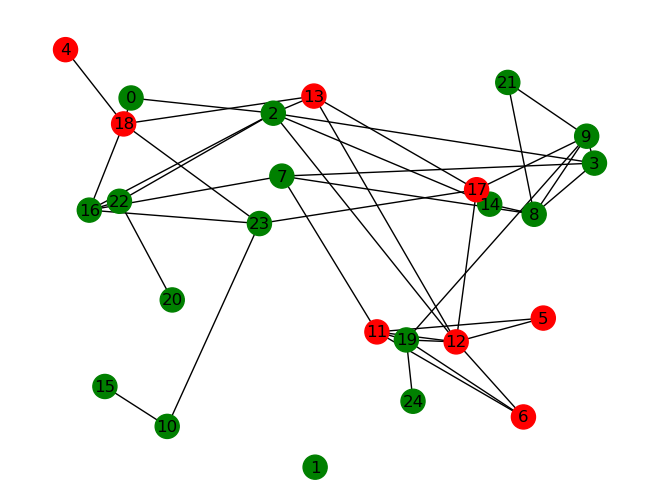

In [11]:
graph = temporal_graph_dict[3]
colors = [color_map[graph.nodes[node]['state']] for node in graph.nodes()]
nx.draw(graph, pos = custom_pos, node_color = colors, with_labels = True)

In [12]:
'''
Meanfield inference of state probabilities in graph given graph dictionary of [0, t] we predict state probabilities at time t + 1
@param: graph - networkx graph, temporal_graph_dict - dictionary of graphs, t_MR - time of lookback for observation, t - time of inference (standard to be t = len(temporal_graph_dict))
- infection_rate, - recovery_rate
@pre: t_MR < t, t_MR > 0
@returns: dictionary of state probabilities at time t + 1 {node: {'S': prob, 'I': prob, 'R': prob}}
'''

"\nMeanfield inference of state probabilities in graph given graph dictionary of [0, t] we predict state probabilities at time t + 1\n@param: graph - networkx graph, temporal_graph_dict - dictionary of graphs, t_MR - time of lookback for observation, t - time of inference (standard to be t = len(temporal_graph_dict))\n- infection_rate, - recovery_rate\n@pre: t_MR < t, t_MR > 0\n@returns: dictionary of state probabilities at time t + 1 {node: {'S': prob, 'I': prob, 'R': prob}}\n"

In [ ]:
def SurroundInfectionRate(graph, node, infection_rate):
    neighbors = list(graph.neighbors(node))
    result = 0
    for neighbor in neighbors:
        result += infection_rate * graph.nodes[neighbor]['SIR_prob'][1]
    return result

In [15]:
def MeanFieldInference(graph_t, infection_rate, recovery_rate):
    predicted_state_t1 = {}
    for node in graph_t.nodes():
        factor = SurroundInfectionRate(graph_t, node, infection_rate)
        Ps = graph_t.nodes[node]['SIR_prob'][0]*(1-factor)
        Pi = (1-recovery_rate)*graph_t.nodes[node]['SIR_prob'][1] + graph_t.nodes[node]['SIR_prob'][0]*factor
        Pr = graph_t.nodes[node]['SIR_prob'][2] + recovery_rate*graph_t.nodes[node]['SIR_prob'][1]
        predicted_state_t1[node] = [Ps, Pi, Pr]
    return predicted_state_t1
